In [176]:

import torch

import torch.nn.functional as F
import matplotlib.pyplot as plt

In [23]:
with open('names.txt', 'r') as fp:
    words = fp.read().splitlines()
    
words[:2]

['emma', 'olivia']

In [24]:
chars = sorted(list(set("".join(words))))

In [25]:
char_to_i = {char:i+1 for i, char in enumerate(chars)}
char_to_i['.'] = 0
i_to_char = {i:s for s, i in char_to_i.items()}
print(i_to_char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [26]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = char_to_i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [27]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [28]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [29]:
C = torch.randn((27, 2))

In [30]:
C[X].shape

torch.Size([228146, 3, 2])

In [31]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [32]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [33]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [34]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [37]:
counts = logits.exp()

counts.shape

torch.Size([228146, 27])

In [41]:
probs = counts/counts.sum(dim=1, keepdims=True)

In [42]:
probs.shape

torch.Size([228146, 27])

In [43]:
probs[0].sum()

tensor(1.0000)

In [45]:
preds = torch.argmax(probs, dim=1)
preds

tensor([26, 26, 23,  ..., 14, 13,  0])

In [66]:
loss = -probs[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(13.7164)

In [143]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = char_to_i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [191]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [192]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [193]:
print("num parameters", sum(p.nelement() for p in parameters))

num parameters 3481


In [194]:
for p in parameters:
    p.requires_grad = True

In [195]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

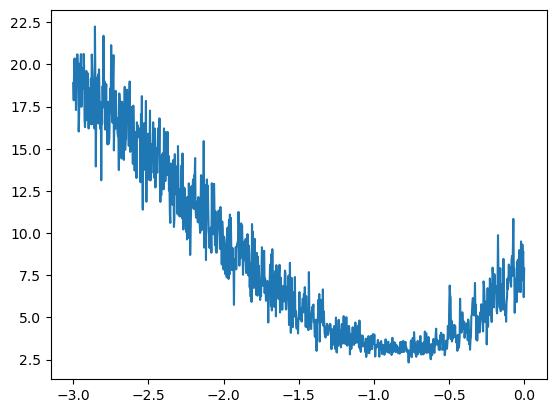

In [190]:
plt.plot(lri, lossi)

In [206]:
lri, lossi = [], []

for i in range(10000):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # loss
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
#     lri.append(lre[i])
#     lossi.append(loss.item())

In [207]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3221, grad_fn=<NllLossBackward0>)